In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns
import math

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
fangraphs = pd.read_csv('./fangraphs_season_level.csv')
savant = pd.read_csv('./savant_pitch_level.csv')

savant.loc[savant['balls'] == 4, 'balls'] = 3
savant.loc[savant['strikes'] == 3, 'strikes'] = 2

In [4]:
savant.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,hit_location,balls,strikes,game_year,...,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced
count,2135260.00,2135075.00,2135075.00,2136337.00,2136337.00,2135285.00,477478.00,2136337.00,2136337.00,2136337.00,...,2136337.00,2136337.00,2126707.00,2136337.00,2136199.00,2136337.00,2136337.00,2136337.00,2136337.00,2136337.00
mean,88.91,-0.79,5.81,615015.87,612938.96,9.08,5.09,0.88,0.90,2022.00,...,2.26,2.27,175.59,0.00,0.00,0.57,0.43,31.21,8.32,1.47
std,6.10,1.85,0.55,61021.46,62150.60,4.23,2.63,0.97,0.83,0.82,...,2.56,2.64,72.04,0.03,0.24,0.49,0.49,26.64,6.90,0.70
min,30.10,-5.34,0.76,405395.00,405395.00,1.00,1.00,0.00,0.00,2021.00,...,0.00,0.00,0.00,-0.78,-1.54,0.00,0.00,1.00,1.00,1.00
25%,84.60,-2.10,5.54,592206.00,592662.00,5.00,2.00,0.00,0.00,2021.00,...,0.00,0.00,132.00,0.00,-0.07,0.00,0.00,9.00,3.00,1.00
50%,89.80,-1.49,5.85,641154.00,623352.00,11.00,5.00,1.00,1.00,2022.00,...,1.00,1.00,199.00,0.00,-0.02,1.00,0.00,22.00,6.00,1.00
75%,93.80,0.98,6.15,664702.00,663752.00,13.00,8.00,2.00,2.00,2023.00,...,3.00,4.00,222.00,0.00,0.04,1.00,1.00,50.00,13.00,2.00
max,104.80,4.75,8.11,807799.00,701643.00,14.00,9.00,4.00,3.00,2023.00,...,28.00,28.00,360.00,0.91,3.65,1.00,1.00,131.00,35.00,5.00


In [24]:
len(list(fangraphs.groupby('Name').filter(lambda x: ('SP' in x['Role'].values and 'RP' in x['Role'].values) and (x['G'].sum() >= 50))['Name'].unique()))



240

In [5]:
savant.pitch_name.value_counts() / len(savant) * 100

pitch_name
4-Seam Fastball   33.58
Slider            17.67
Sinker            15.41
Changeup          11.14
Curveball          7.52
Cutter             7.34
Sweeper            2.87
Knuckle Curve      2.01
Split-Finger       1.78
Slurve             0.35
Other              0.15
Eephus             0.05
Forkball           0.04
Slow Curve         0.01
Knuckleball        0.01
Pitch Out          0.01
Screwball          0.00
Name: count, dtype: float64

In [28]:
savant.description.unique()
# swinging_strike, foul_tip, swinging_strike_blocked, bunt_foul_tip, missed_bunt

array(['swinging_strike', 'foul', 'ball', 'hit_into_play', 'blocked_ball',
       'called_strike', 'foul_tip', 'hit_by_pitch', 'foul_bunt',
       'swinging_strike_blocked', 'missed_bunt', 'pitchout',
       'bunt_foul_tip', 'foul_pitchout', 'unknown_strike'], dtype=object)

In [38]:
fangraphs.columns

Index(['PlayerId', 'MLBAMID', 'Name', 'NameASCII', 'Throws', 'Season', 'Age',
       'Team', 'Role', 'G',
       ...
       'Pit_plus_FC', 'Stf_plus_FS', 'Loc_plus_FS', 'Pit_plus_FS',
       'Stf_plus_FO', 'Loc_plus_FO', 'Pit_plus_FO', 'Stuff_plus',
       'Location_plus', 'Pitching_plus'],
      dtype='object', length=308)

In [42]:
savant['pitch_type'].unique()

array(['FF', 'SL', 'CU', 'SI', 'CH', 'FS', 'KC', 'FC', 'SV', 'ST', 'FA',
       'CS', 'PO', 'EP', nan, 'SC', 'KN', 'FO'], dtype=object)

In [42]:
matrix = [[0, 0, 0, 0, .461], [1, 0, 0, 0, .831], [0, 1, 0, 0, 1.068], [1, 1, 0, 0, 1.373], [0, 0, 1, 0, 1.426], [1, 0, 1, 0, 1.798], [0, 1, 1, 0, 1.92], [1, 1, 1, 0, 2.282],
          [0, 0, 0, 1, .243], [1, 0, 0, 1, .489], [0, 1, 0, 1, .644], [1, 1, 0, 1, .908], [0, 0, 1, 1, .865], [1, 0, 1, 1, 1.14], [0, 1, 1, 1, 1.352], [1, 1, 1, 1, 1.52],
          [0, 0, 0, 2, .095], [1, 0, 0, 2, .214], [0, 1, 0, 2, .305], [1, 1, 0, 2, .343], [0, 0, 1, 2, .413], [1, 0, 1, 2, .471], [0, 1, 1, 2, .570], [1, 1, 1, 2, .736]
         ]

run_exp = pd.DataFrame(matrix, columns=['on_1b', 'on_2b', 'on_3b', 'outs', 'run_exp'])

data = savant.sort_values(by=['game_date','pitcher', 'pitch_number_appearance'])

data[['on_1b', 'on_2b', 'on_3b']] = data[['on_1b', 'on_2b', 'on_3b']].applymap(lambda x: 1 if pd.notnull(x) else 0)
data = data.rename(columns={'outs_when_up': 'outs'})

data['runs'] = (data['post_home_score'] - data['home_score']) + (data['post_away_score'] - data['away_score'])

# Merge Run expected values
data = pd.merge(data, run_exp, how='left', on=['on_1b', 'on_2b', 'on_3b', 'outs'])

data['run_exp_chg'] = np.where(data['pitch_number_appearance'] == 1, 0.00, round(-data['run_exp'].diff(1), 3).fillna(-.098))

data['run_exp_end'] = data['run_exp'] + data['run_exp_chg']
data['events'].replace(['field_out', 'strikeout',
       'grounded_into_double_play','fielders_choice_out','double_play', 'caught_stealing_2b', 'caught_stealing_3b',
        'strikeout_double_play', 'other_out',
       'pickoff_2b', 'pickoff_caught_stealing_2b',
       'pickoff_caught_stealing_3b', 'triple_play', 'pickoff_1b', 'sac_bunt_double_play','caught_stealing_home', 'pickoff_3b',
       'pickoff_caught_stealing_home'], 'field_out', inplace=True)

data['outs_end_inn'] = [1 if x=='field_out' and y ==2 else 0 for (x,y) in zip(data['events'], data['outs'])]

# Resets the ending run expected value
data['run_exp_end'] = [0 if x==1 else y for (x,y) in zip(data['outs_end_inn'], data['run_exp_end'])]

data['run_exp_chg'] = [-y if x == 1 else z for (x,y,z) in zip(data['outs_end_inn'], data['run_exp'], data['run_exp_chg'])]


data['run_exp_chg'].replace([-0.000], 0.000, inplace=True)

data['re24'] = data['run_exp_chg'] + data['runs']

In [43]:
wra_matrix = [
    [0, 0, 0.314, 1, 0, -0.034],
    [0, 0, 0.314, 0, 1, 0.028],
    [0, 1, 0.265, 1, 0, -0.047],
    [0, 1, 0.265, 0, 1, 0.024],
    [0, 2, 0.197, 1, 0, -0.135],
    [0, 2, 0.197, 0, 1, 0.017],
    [1, 0, 0.356, 1, 0, -0.038],
    [1, 0, 0.356, 0, 1, 0.048],
    [1, 1, 0.300, 1, 0, -0.053],
    [1, 1, 0.300, 0, 1, 0.039],
    [1, 2, 0.222, 1, 0, -0.152],
    [1, 2, 0.222, 0, 1, 0.032],
    [2, 0, 0.426, 1, 0, -0.047],
    [2, 0, 0.426, 0, 1, 0.078],
    [2, 1, 0.357, 1, 0, -0.06],
    [2, 1, 0.357, 0, 1, 0.082],
    [2, 2, 0.269, 1, 0, -0.184],
    [2, 2, 0.269, 0, 1, 0.075],
    [3, 0, 0.540, 1, 0, -0.043],
    [3, 0, 0.540, 0, 1, 0.104],
    [3, 1, 0.477, 1, 0, -0.067],
    [3, 1, 0.477, 0, 1, 0.147],
    [3, 2, 0.379, 1, 0, -0.05],
    [3, 2, 0.379, 0, 1, 0.214]
]


wra = pd.DataFrame(wra_matrix, columns=['balls', 'strikes', 'woba', 'is_strike', 'is_ball', 'wraa_change'])


In [44]:
data['is_ball'] = [1 if x == 'B' else 0 for x in data['type']]
data['is_strike'] = [1 if x != 'B' else 0 for x in data['type']]

data = pd.merge(data, wra, how='left', on=['balls', 'strikes', 'is_ball', 'is_strike'])

data['rv'] = data['re24']

data['rv'] = [y if x == 0 else x for (x,y) in zip(data['rv'], data['wraa_change'])]
data['rv'] = [x if not pd.isna(x) else -0.098 for x in data['rv']]

data['rv/100'] = data['rv'] / data.groupby(['player_name', 'pitch_name', 'game_year'])['pitch_number_appearance'].transform('sum') * 100





In [63]:
data[data['game_year'] == 2023].groupby(['player_name', 'pitch_name']).agg({'rv': 'sum'}).sort_values(by='rv', ascending=True).head(10)


,,rv
player_name,pitch_name,
"Webb, Logan",Changeup,-35.177
"Eflin, Zach",Sinker,-34.467
"Morton, Charlie",Curveball,-33.386
"Bassitt, Chris",Sinker,-32.885
"Cole, Gerrit",4-Seam Fastball,-31.194
"Gausman, Kevin",Split-Finger,-30.170
"Castillo, Luis",4-Seam Fastball,-26.302
"Gray, Sonny",Sweeper,-25.780
"Luzardo, Jesús",4-Seam Fastball,-24.628


In [7]:
# Qualified SP = 162 Innings

fangraphs['Inn_per_appear'] = fangraphs.apply(lambda row: math.ceil(row['IP'] / row['G']) if row['G'] != 0 else 0, axis=1)

fangraphs[fangraphs['Role'] == 'SP']


,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,Stf_plus_FS,Loc_plus_FS,Pit_plus_FS,Stf_plus_FO,Loc_plus_FO,Pit_plus_FO,Stuff_plus,Location_plus,Pitching_plus,Inn_per_appear
2179,1157,488984,Tommy Hunter,Tommy Hunter,R,2021,34,NYM,SP,1,...,NaN,NaN,NaN,NaN,NaN,NaN,96.165,114.753,107.765,2
2180,1943,425844,Zack Greinke,Zack Greinke,R,2021,37,HOU,SP,29,...,NaN,NaN,NaN,NaN,NaN,NaN,92.100,102.272,98.103,6
2181,2233,425794,Adam Wainwright,Adam Wainwright,R,2021,39,STL,SP,32,...,NaN,NaN,NaN,NaN,NaN,NaN,108.526,103.572,102.683,7
2182,2429,446372,Corey Kluber,Corey Kluber,R,2021,35,NYY,SP,16,...,NaN,NaN,NaN,NaN,NaN,NaN,106.694,99.885,101.342,5
2183,2520,458681,Lance Lynn,Lance Lynn,R,2021,34,CHW,SP,28,...,NaN,NaN,NaN,NaN,NaN,NaN,103.711,103.259,102.418,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,27758,690986,Kyle Harrison,Kyle Harrison,L,2023,21,SFG,SP,7,...,NaN,NaN,NaN,NaN,NaN,NaN,95.130,99.157,97.886,5
3321,29832,680232,Jackson Wolf,Jackson Wolf,L,2023,24,SDP,SP,1,...,NaN,NaN,NaN,NaN,NaN,NaN,116.755,97.617,98.347,5
3322,29911,671096,Andrew Abbott,Andrew Abbott,L,2023,24,CIN,SP,21,...,NaN,NaN,NaN,NaN,NaN,NaN,86.593,100.785,96.962,6
3323,29928,689266,Dylan Dodd,Dylan Dodd,L,2023,25,ATL,SP,7,...,NaN,NaN,NaN,NaN,NaN,NaN,81.532,106.065,97.501,5


In [176]:
players_wanted = fangraphs[(fangraphs['Role'] == 'SP')]
players_wanted = players_wanted['MLBAMID'].unique()
len(players_wanted)

645

In [177]:
sp = data[(data['pitcher'].isin(players_wanted)) & (data['role_key'] == 'SP')].reset_index(drop=True)

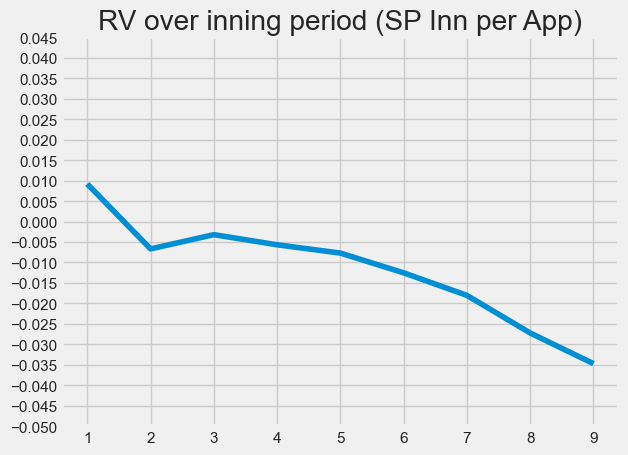

In [174]:
# Lets plot the average rv/100 per IP line chart
test = sp
plt.plot(test['inning'].unique(), test.groupby('inning').agg({'rv' : 'mean'}))
plt.yticks(np.arange(-0.05, 0.05, 0.005))
plt.title('RV over inning period (SP Inn per App)')
plt.show()

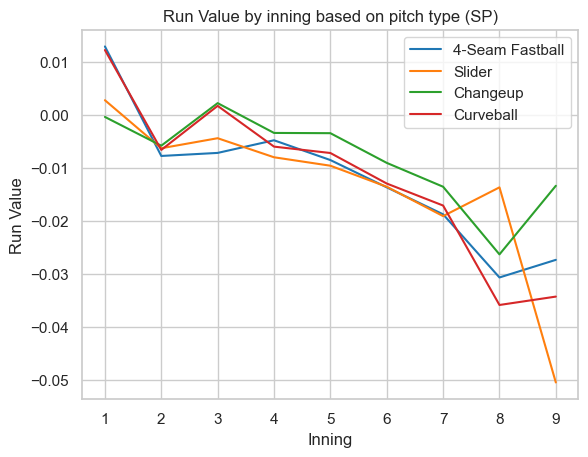

In [85]:
# At bat number vs. Run value on a particular pitch
sns.set(style="whitegrid")
sp = data[data['role_key'] == 'SP']
cool = sp[sp['pitch_name'].isin(['4-Seam Fastball', 'Slider', 'Changeup', 'Curveball'])]
pitch_types = cool['pitch_name'].unique()

colors = plt.cm.tab10(np.arange(len(pitch_types)))

for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('inning')['rv'].mean()
    plt.plot(s.index, s, label=pitch_type, color=color)


plt.title('Run Value by inning based on pitch type (SP)')
plt.xlabel('Inning')
plt.ylabel('Run Value')
plt.legend()
plt.show()

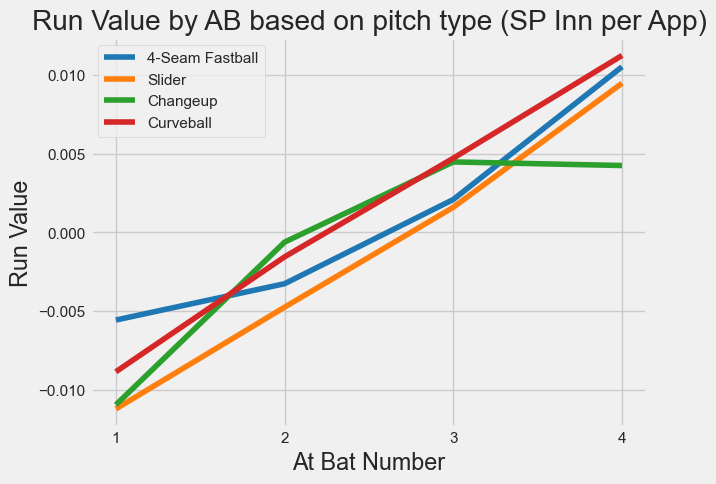

In [173]:
# At bat number vs. Run value on a particular pitch
cool = sp[sp['pitch_name'].isin(['4-Seam Fastball', 'Slider', 'Changeup', 'Curveball']) & (sp['times_faced'] < 5)]
pitch_types = cool['pitch_name'].unique()

colors = plt.cm.tab10(np.arange(len(pitch_types)))

for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('times_faced')['rv'].mean()
    plt.plot(s.index, s, label=pitch_type, color=color)

plt.title('Run Value by AB based on pitch type (SP Inn per App)')
plt.xlabel('At Bat Number')
plt.ylabel('Run Value')
plt.xticks(range(1,5))
plt.legend()
plt.show()

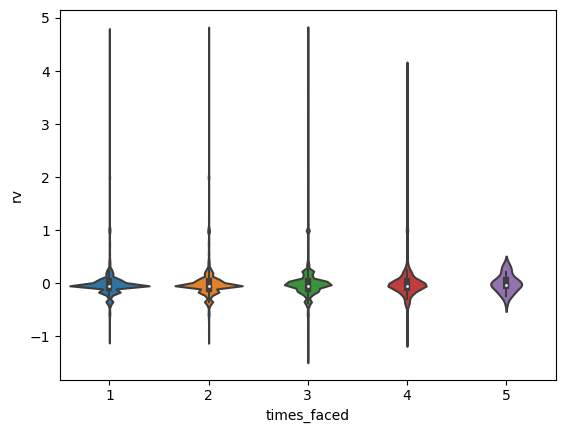

In [14]:
# Violin plot
sup = sp
sns.violinplot(x='times_faced', y='rv', data=sup)
plt.show()

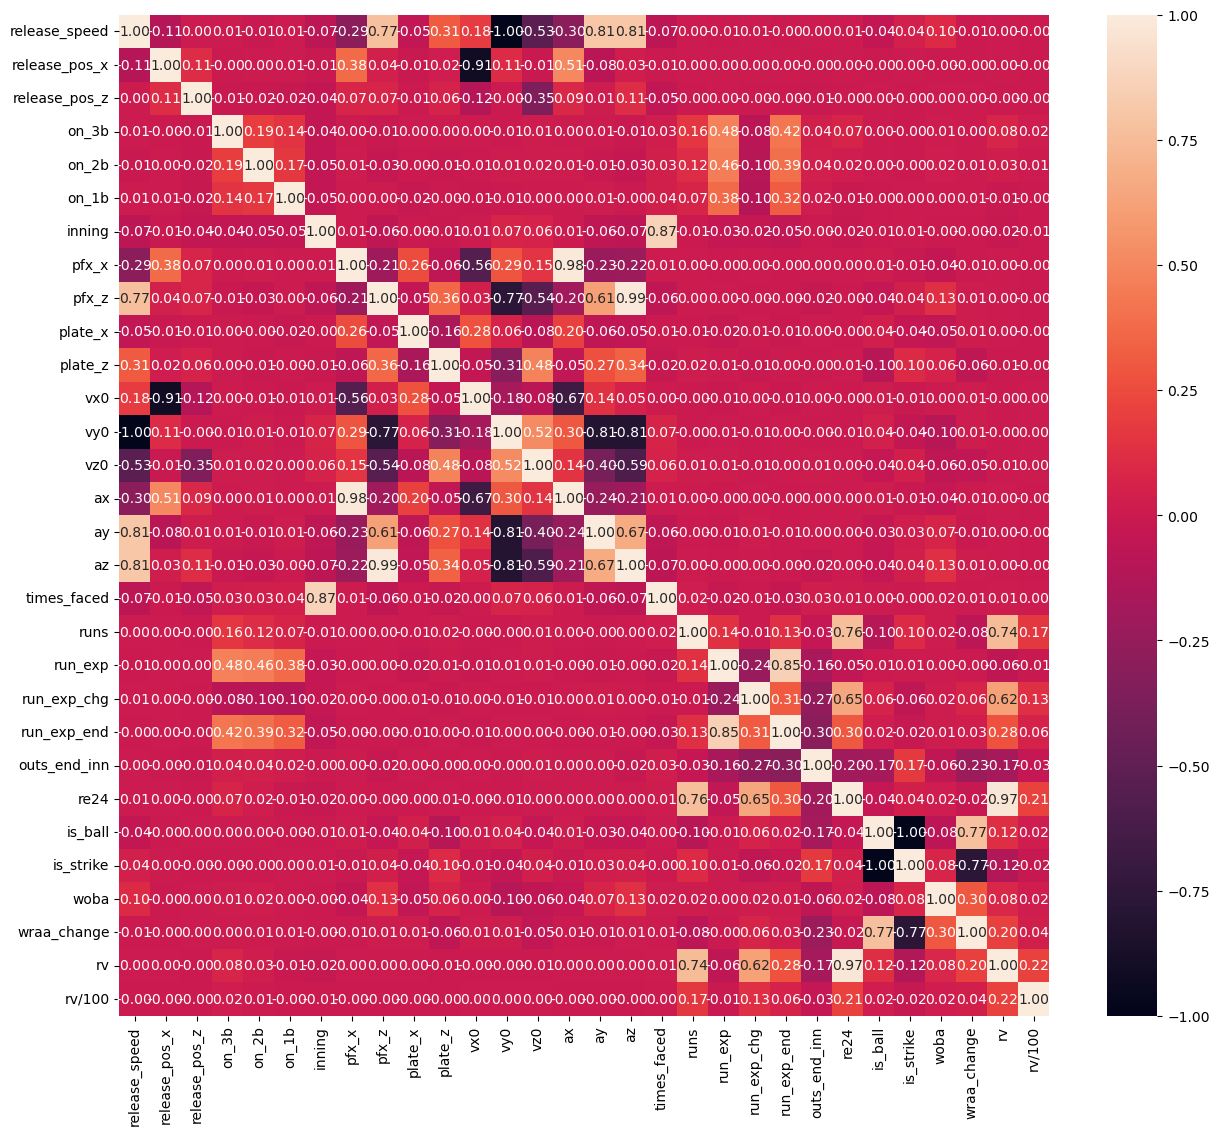

In [18]:
cool = sp[['release_speed',
 'release_pos_x',
 'release_pos_z','on_3b',
 'on_2b',
 'on_1b',
 'inning','pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z','vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az','times_faced',
 'runs',
 'run_exp',
 'run_exp_chg',
 'run_exp_end',
 'outs_end_inn',
 're24',
 'is_ball',
 'is_strike',
 'woba',
 'wraa_change',
 'rv',
 'rv/100']]
fig, ax = plt.subplots(figsize=(15,13))
sns.heatmap(cool.corr(), annot=True, fmt='.2f', ax=ax)
plt.show()

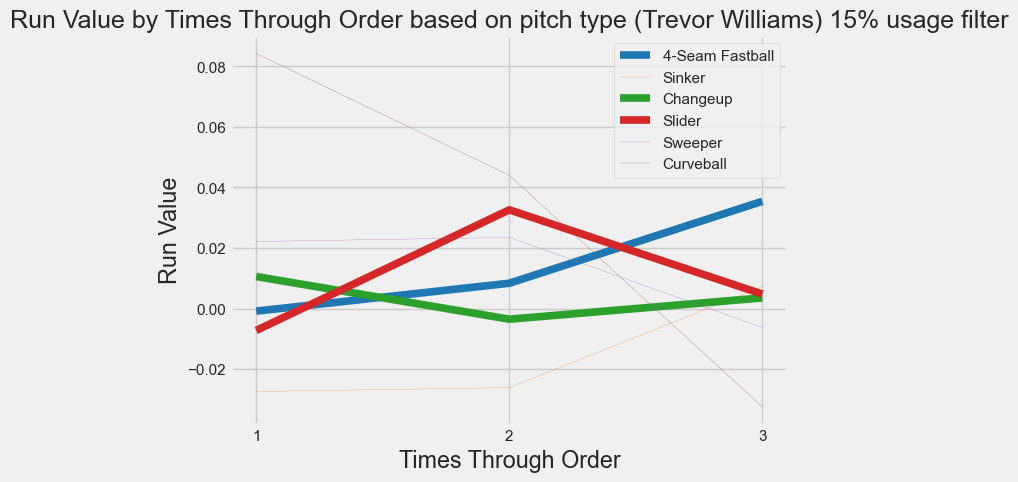

In [157]:
cool = sp[(sp['player_name'] == 'Williams, Trevor') & (sp['times_faced'] < 4) & (sp['game_year'] == 2023)]
pitch_types = cool['pitch_name'].unique()
colors = plt.cm.tab10(np.arange(len(pitch_types)))
total_pitches = cool['pitch_name'].count()
for pitch_type, color in zip(pitch_types, colors):
    subset = cool[cool['pitch_name'] == pitch_type]
    s = subset.groupby('times_faced')['rv'].mean()
    
    pitch_usage = subset['pitch_name'].count() / total_pitches
    
    if pitch_usage >= .15:
        width = 5.5
    else:
        width = 0.2 
        
        
    plt.plot(s.index, s, label=pitch_type, color=color, linewidth = width)

plt.title('Run Value by Times Through Order based on pitch type (Trevor Williams) 15% usage filter', fontsize=18)
plt.xlabel('Times Through Order')
plt.ylabel('Run Value')
plt.xticks(range(1,4))
plt.legend()
plt.show()

In [172]:
filtered = fangraphs[(fangraphs['Role'] == 'SP') & (fangraphs['Season'] == 2023) & (fangraphs['FIP_minus'] >= 95) & ((fangraphs['Stuff_plus'] >= 90) & (fangraphs['Stuff_plus'] <= 100)) & (fangraphs['Age'] >= 26) & (fangraphs['Age'] < 31) & (fangraphs['IP'] <= 100)]



In [144]:
elite_relievers = fangraphs[(fangraphs['Role'] =='RP') & (fangraphs['SD'] >= 30)]['MLBAMID'].unique()
qualifying_players = fangraphs[fangraphs['Role'] =='RP'].groupby('Name')['G'].mean()
qual_relievers = fangraphs[(fangraphs['Role'] == 'RP') & (qualifying_players.mean() >= 15)]['MLBAMID'].unique()


In [171]:
fangraphs[fangraphs['Role'] == 'RP'][['Name', 'SD']].sort_values(by='SD', ascending=False)

,Name,SD
272,Tyler Rogers,43
788,Devin Williams,42
1277,Devin Williams,42
2074,Tanner Scott,41
1672,Will Smith,39
...,...,...
859,Triston McKenzie,0
851,Max Schrock,0
1600,Darius Vines,0
1601,Quinn Priester,0


In [145]:
def player_comp(player, metrics, qual_relievers):
    relievers = data[data['pitcher'].isin(qual_relievers)][metrics].dropna()
    relievers = relievers.groupby(['pitcher', 'pitch_name'], as_index=True).mean()
    
    player = savant[savant['player_name'] == player][metrics].dropna()
    player = player.groupby(['pitcher', 'pitch_name'], as_index=True).mean()
    
    def calculate_distance(row):
        return euclidean(row.values, player.mean(axis=0).values)

    relievers['distance'] = relievers.apply(calculate_distance, axis=1)

    similar_relievers = relievers.sort_values(by='distance').head(10)
    return similar_relievers

In [146]:
# Elite Ceiling
pitchers_to_compare = ['Kopech, Michael', 'Peterson, David', 'Williams, Trevor']

selected_metrics = ['pitcher', 'pitch_name', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
    'release_speed', 'release_spin_rate', 'effective_speed',
    'launch_speed', 'launch_angle',
    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle'
]

kopech = pitchers_to_compare[0]
peterson = pitchers_to_compare[1]
williams = pitchers_to_compare[2]

kopech_elite = player_comp(kopech, selected_metrics, elite_relievers)
peterson_elite = player_comp(peterson, selected_metrics, elite_relievers)
williams_elite = player_comp(williams, selected_metrics, elite_relievers)

In [147]:
# Realistic Ceiling

kopech_real = player_comp(kopech, selected_metrics, qual_relievers)
peterson_real = player_comp(peterson, selected_metrics, qual_relievers)
williams_real = player_comp(williams, selected_metrics, qual_relievers)

In [165]:
williams_elite

,,pfx_x,pfx_z,plate_x,plate_z,release_speed,release_spin_rate,effective_speed,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,distance
pitcher,pitch_name,,,,,,,,,,,,
650893,Cutter,-0.032,0.472,0.013,2.081,89.533,2103.500,89.406,91.075,7.146,0.334,0.383,17.345
459429,4-Seam Fastball,0.974,1.244,0.013,2.577,94.672,2108.492,94.309,90.784,21.708,0.298,0.360,26.508
640448,Slider,0.299,0.619,0.324,2.298,87.910,2116.254,88.568,81.728,8.268,0.315,0.362,27.437
455119,Sinker,-1.235,0.853,-0.524,2.446,94.831,2070.343,95.120,83.053,-0.514,0.273,0.269,28.302
623352,Sinker,0.717,1.470,-0.124,2.661,96.609,2065.326,97.316,87.676,21.425,0.301,0.339,32.617
571670,Sinker,-1.409,0.704,-0.465,2.457,92.903,2127.310,92.918,87.421,2.098,0.330,0.336,40.701
661395,4-Seam Fastball,-0.939,1.099,0.119,2.596,101.247,2121.496,101.387,87.291,3.124,0.310,0.330,41.081
605280,4-Seam Fastball,-0.670,0.655,0.630,2.995,96.400,2121.500,95.600,92.800,-8.000,0.211,0.203,41.699
623465,Sinker,-1.308,0.607,-0.451,2.346,95.686,2125.690,96.159,88.848,-2.207,0.312,0.319,42.145


In [170]:
savant[savant['pitcher'] == 650893].player_name

5827       Cabrera, Génesis
5908       Cabrera, Génesis
5945       Cabrera, Génesis
5993       Cabrera, Génesis
6088       Cabrera, Génesis
                 ...       
2135394    Cabrera, Génesis
2135516    Cabrera, Génesis
2135746    Cabrera, Génesis
2135825    Cabrera, Génesis
2135946    Cabrera, Génesis
Name: player_name, Length: 2877, dtype: object

In [222]:
data[data['player_name'] == 'Kopech, Michael'].groupby(['player_name', 'game_year', 'pitch_name']).agg({'rv/100' : 'sum', 'rv':'sum', 'delta_run_exp':'sum'})



rv/100     rv  delta_run_exp
player_name     game_year pitch_name                                   
Kopech, Michael 2021      4-Seam Fastball  -0.044 -5.784         -4.867
                          Changeup         -0.118 -1.026         -0.006
                          Curveball         0.158  1.255         -0.231
                          Slider           -0.036 -2.174         -1.491
                2022      4-Seam Fastball  -0.017 -8.927         -5.841
                          Changeup         -0.008 -0.088         -0.253
                          Curveball         0.018  2.081         -3.348
                          Pitch Out         0.141  0.048          0.000
                          Slider           -0.021 -4.513          3.036
                2023      4-Seam Fastball  -0.006 -4.207          3.936
                          Changeup          0.073  6.466          2.285
                          Curveball         0.089  4.668          0.421
                          Slider            0.035 10.340          7.118

/Users/eddie/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/eddie/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


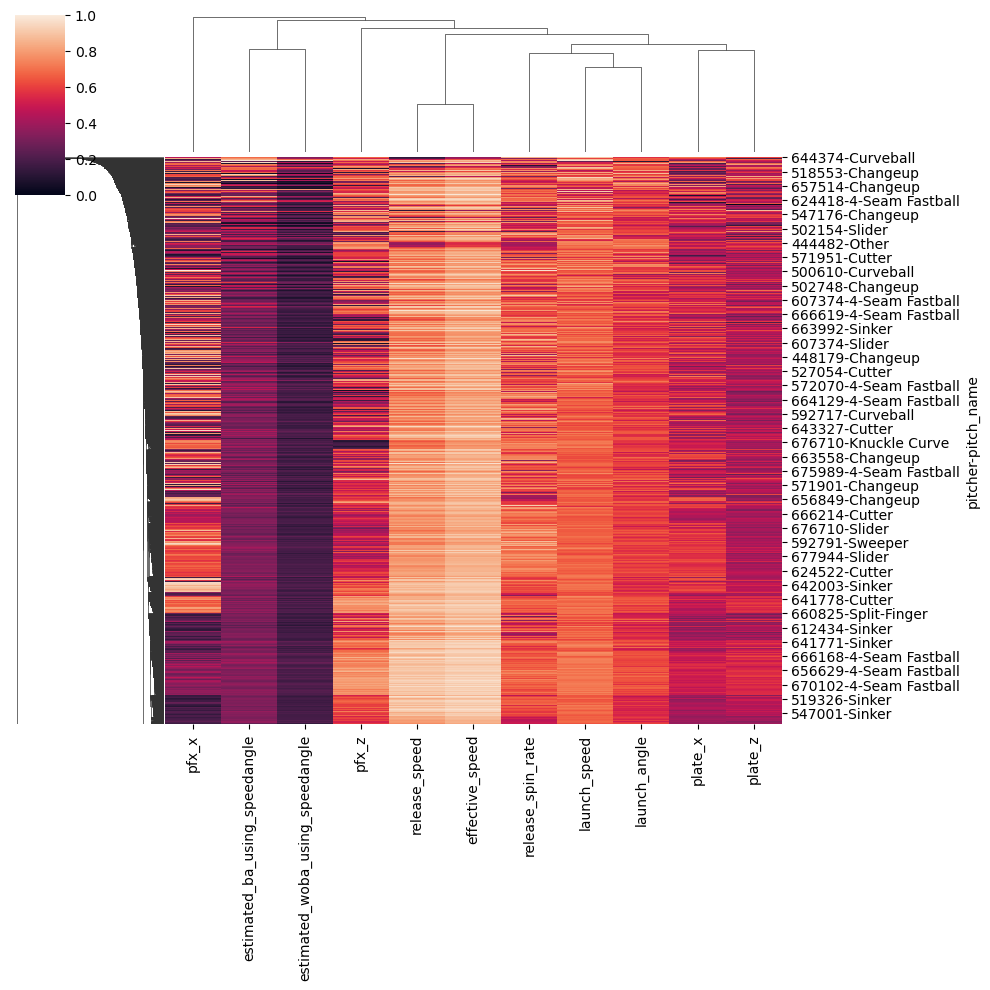

In [240]:
relievers = data[data['pitcher'].isin(qual_relievers)][selected_metrics].dropna()
relievers = relievers.groupby(['pitcher', 'pitch_name'], as_index=True).mean()

sns.clustermap(relievers, metric='euclidean', standard_scale=1, method='single')

plt.show()